### <font color= 'white'> S&P 500 PostCovid *Optimizations & ML models*<font> 

##### [![S&P500-PostCovid_ML](https://img.shields.io/badge/Repository-S&P500--PostCovid--ML-020521?style=flat-square&logo=github&logoColor=white)](https://mango-dune-07a8b7110.1.azurestaticapps.net/?repo=EstebanMqz%2FSP500-Risk-Optimized-Portfolios-PostCovid-ML)

##### <font color= 'blue'> *Introduction.* <font>

<font color= 'black'> 
Time series modelling is a powerful forecast tool and the stock market tends to be an interesting example because statistical estimators are of special interest.<br> 
They are used used in all types of industries, including but not limited to:<br>

- Government
- Banking
- Insurance
- Energy
- Healthcare
- Telecommunications
- Retail
- Education

This is made in order to predict variables, their interaction with other variables and for decision-making per se.


##### <font color= 'blue'> *Objective.* <font>

<font color= 'black'>

In this project, parameters $r_{t}$ $\&$ $\sigma_i$ and Disperssion metrics are calculated in order to analyze and predict $X_i\in [X_1,X_{500}]$ in the $S\&P500$ individually.<br> 
Then, optimizations are made based on certain requirements and constraints for $X_{P{_{R{max}}}}$ vs $X_{P{_{R_{j}}}}$ in order to implement a ML model to predict $X_{P{_{R{max}}}}$<br>

### <font color= 'blue'> 0. Requirements. <font>

##### <font color= 'blue'> 0.1 <u> Load Dependencies: </u><font>

In [1]:
import functions as fn
import data as dt
import visualizations as vs 

##### <font color= 'blue'> 0.2 <u> Install Libs. & Modules: </u><font>

<span style='color:black'> Project Creators: Create <\span> `requirements.txt` file:

<span style='color:gray'> *Skip to `requirements.txt` installation if not contributing to the project.* <font>

In [2]:
docstring = """
# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 
\n
"""

path = fn.get_requirements(docstring)

requirements.txt file created in local path: c:\Users\Esteban\Desktop\Projects\Github\Repos_To-do\Languages\Python\Fin_Sim\Projects\SP500-Risk-Optimized-Portfolios-ML\requirements.txt


<span style='color:black'> Project Users: Install packages in <\span> `requirements.txt` file: <br>

In [3]:
fn.library_install("requirements.txt")

Requirements installed.

# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 


numpy >= 1.22.4 
pandas >= 1.4.4 
matplotlib >= 3.5.3 
scipy >= 1.7.3 
sklearn >= 1.0.2 
logging >= 0.5.1.2 
jupyter >= 1.0.0 
yahoofinanicals >= 1.14 
tabulate >= 0.8.9 
IPython >= 8.12.0 
fitter >= 1.5.2 



##### <font color= 'blue'> 0.3 <u> Load Libraries & Modules </u><font>

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None
              ,"display.max_colwidth", None, "display.width", None)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d
import IPython.core.display

import datetime 
import time

from io import StringIO
from fitter import Fitter, get_common_distributions, get_distributions 
import logging
import ast

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

### <font color= 'blue'> 1. Data Extraction <font>

<span style='color:black'>
The following are the $S\&P500$ quotes symbols from *A-Z*:

<span style='color:gray'> *Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions (other sources could be used).* <font> &nbsp;

In [3]:
tickers=fn.SP500_tickers(50)
tickers[0][0:5], tickers[-1][0:5]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

#### <font color= 'blue'> 1.1 <u> Fetching Data </u><font> </span>


<span style='color:gray'> *Skip to 1.2 if you prefer using .csv creation date rather than execution's date.* <font> &nbsp; 


<span style='color:black'>

$6_Y$ of adj closes from the $S\&P$ $500$ quotes are fetched *(5min.)*.

In [7]:
SP_Assets_f = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) 
                         for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

In [8]:
SP_f = dt.get_historical_price_data('^GSPC', 6)
SP_f = SP_f[SP_f.index.isin(SP_Assets_f.index)]

<span style='color:black'>

Fetched data saved in `Assets_SP500.csv` $\&$ `SP500_index.csv` files in *subdirectory $\rightarrow$ `Data`*

In [9]:
SP_Assets_f.to_csv("Data/Assets_SP500.csv")   
SP_f.to_csv("Data/SP500.csv")

In [5]:
SP_Assets_f.head(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OGN,OTIS,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,161.040298,47.841511,38.806999,50.266289,110.057076,53.495720,34.953686,134.539993,86.790016,137.649139,9.207948,31.724340,53.345463,123.802734,47.000000,78.261253,102.006996,98.774345,137.690002,72.405930,33.232967,74.185806,47.525002,46.512001,47.018024,47.924500,8.57413,11.28,46.926453,43.335861,55.686264,70.088387,52.156334,112.840866,67.771461,108.993820,78.687935,56.812534,133.256943,34.139397,71.582138,120.339996,119.744476,44.245636,35.886818,40.840878,69.673462,31.753332,35.869999,49.738522,87.769371,17.833265,70.305252,95.830002,673.789978,156.858948,74.248489,24.129999,33.547867,37.562801,20.000603,32.546429,52.764774,164.347321,26.127310,161.619995,42.327358,221.610001,26.360933,252.809998,333.644592,39.364826,167.159943,1796.030029,36.418564,96.433662,26.139999,44.850090,192.413727,65.305748,19.964479,38.030876,58.150627,59.028461,32.320000,19.950001,68.041763,47.105587,71.190224,58.555779,63.709999,55.121964,NaN,33.360001,86.522026,82.824158,33.130001,52.768154,73.603111,37.810001,22.515247,NaN,23.349058,89.400002,35.496414,315.880005,82.120811,484.739990,122.837242,45.916824,153.946152,58.563629,112.794777,26.086765,49.751961,27.405060,111.439079,94.036995,38.531712,36.185768,60.440792,64.089928,33.922573,53.962440,31.412649,38.436550,64.212875,166.180206,NaN,210.145447,14.670,24.520830,NaN,25.174999,157.787918,18.463524,79.883377,15.4717

In [6]:
SP_Assets_f.tail(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OGN,OTIS,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-05,103.349998,70.379997,111.260002,148.029999,265.649994,76.000000,75.510590,348.399994,215.479996,123.769997,22.670000,67.160461,133.300003,296.700012,78.559998,43.160000,179.699997,123.639999,313.640015,108.089996,55.110001,115.730003,105.570000,106.214996,46.689999,105.660004,10.42,89.839996,90.470001,13.87,91.280266,152.649994,53.790001,196.750000,147.722000,291.179993,167.509323,145.020004,236.529999,75.709999,183.389999,301.679993,328.399994,33.220001,173.330261,116.059998,93.419998,74.809998,137.979996,213.820007,130.940002,17.129999,117.559998,194.940002,2691.580078,179.750000,172.080002,219.910004,28.219999,58.599998,27.709999,33.709999,46.049999,253.660004,58.650002,323.880005,73.570000,385.239990,83.048828,318.059998,644.479980,41.169998,198.339996,2569.300049,44.610001,51.930000,51.540001,68.139999,630.119995,152.869995,65.309998,64.669998,90.550003,104.500000,205.240005,44.680000,110.349998,54.740002,87.405952,83.199997,70.610001,10.01,42.380001,47.750000,215.089996,136.580002,74.550003,165.990005,105.900002,68.389999,30.520000,56.700001,69.225349,191.250000,48.981117,350.850006,160.210007,2028.209961,198.929993,97.253738,260.739990,105.239998,465.239075,46.250000,46.320000,26.440001,169.600006,185.130005,61.980000,64.019997,63.290001,80.589996,40.430000,36.439999,37.820000,99.855186,98.671692,223.440002,79.207878,385.940002,78.889999,31.48000

#### <font color= 'blue'> 1.2 <u> Reading data </u><font> </span>

<span style='color:black'>
After fetching data, row simmetry is made with pandas `.isin` method and verified within dataframes.

In [4]:
SP_r = pd.read_csv("Data/SP500.csv", index_col=0)
SP_Assets_r = pd.read_csv("Data/Assets_SP500.csv", index_col=0)

SP_r.shape, SP_Assets_r.shape

((1509, 1), (1509, 503))

### <font color= 'blue'> 2. Descriptive Analytics <font> </span>

##### <font color= 'blue'> 2.1 <u>$X_i$ metrics<u> <font>

<span style='color:black'>

Sharpe's Ratio measures the units of risk *($\small \sigma$)* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sharpe} = \frac{\mu_i - {rf}}{\sigma_i(r_t)}$.
<br>

Sortino's Ratio measures the units of negative risks *[$\sigma_{i}\small(r_{t\leq 0})$]* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sortino} = \frac{\mu_i - {rf}}{\sigma_{i}(r_{t\leq 0})}$ 

<span style='color:black'>

To avoid risks associated to negative returns, Data Selection $\forall X_i\in [X_1,X_{500}] \rightarrow X_{P{_{R{max}}}}$ is based on $S\&P500$ *Sortino's Ratio Top 25*:

|     |   $\mu_{i{yr}}$ |   $\sigma_{yr}$ |   $R_{Sharpe}$ |   $R_{Sortino}$ |
|:----|----------------:|----------------:|---------------:|----------------:|
| LLY |        0.443015 |        0.338796 |        1.25774 |         2.08961 |
| EQT |        0.758006 |        0.649231 |        1.14151 |         2.00162 |
| PWR |        0.542104 |        0.397572 |        1.32103 |         1.91801 |

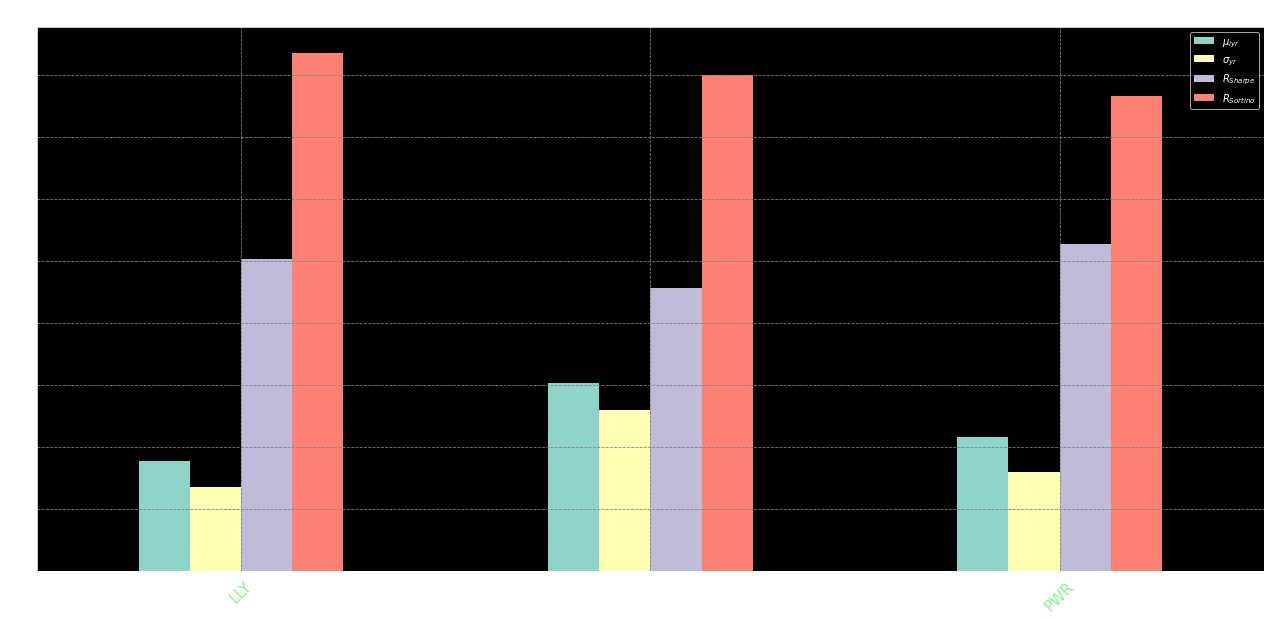

In [13]:
today = (datetime.date.today()).strftime("%Y-%m-%d")
Sortino25 = vs.selection_data(SP_Assets_r.loc["2020-03-02":today], 0.0169, "S&P 500 Metrics from 2020-03-02 to " +str(today), 25)

<span style='color:black'>

The *$AIC$ Akaike $\&$ $BIC$ Bayesian Information Criterion* models are estimators of prediction errors in the *Log-Likelihood* for fitted distributions.<br>
Minimum relative values for $AIC$ and $BIC$ are usually preferred and they are obtained to model $X_i$ resampled data on $W, M$   $\&$ $Q$ periods $P$.<br>
Distribution parameters are criterions are made from the 104 distribution classes and instances for continuous random variables in `Fitter` pkg  *(see refs.)*. <br>
Criterion's goodness of fit is inversely related so they are used together to avoid under/over fitting. They are defined as follows:
+ $AIC = 2k - 2ln(\hat{L})$<br>
+ $BIC = kln(n) - 2ln(\hat{L})$<br>

*where:*<br>

 $k$ = Params. in  model.<br>
 $n$ = No° of observations.<br>
 $\hat{L}$ = $Likelihood_{f_{max.}}$.<br>

In [14]:
dist=([d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))])[0:60]
P = [["W", "Weekly"], ["M", "Monthly"], ["Q", "Qtrly."]]
color=["lightyellow", "lightblue", "lightgreen"]

NameError: name 'IPython' is not defined

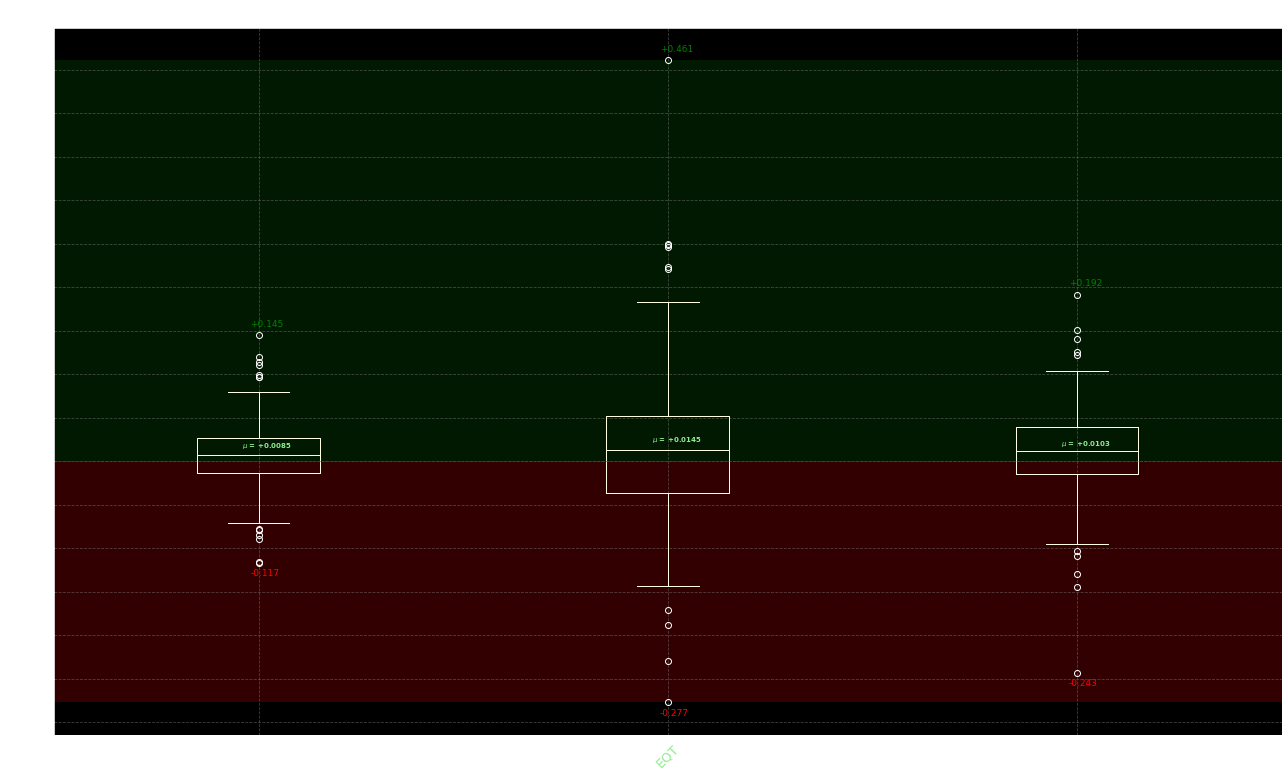

In [15]:
describe_Wk = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[0][0],
                  "S&P 500 Resampling Stats for Sortino Selection on a " + str(P[0][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[0])
describe_Wk[2]

In [ ]:
describe_Mo = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[1][0],
                  "S&P 500 Resampling Stats for Sortino Selection on a " + str(P[1][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[1])
describe_Mo[2]
                  

In [ ]:
describe_Qt = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[2][0],
                  "S&P 500 Resampling Stats for Sortino Selection on a " + str(P[2][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[2])
describe_Qt[2]

##### <font color= 'blue'> 
$X_i$ Estimator Parameters <u> <font>

In [ ]:
dist_fit=pd.DataFrame([describe2[1], describe3[1], describe4[1]])
fn.format_table(dist_fit, Sortino25[2])
    

### <font color= 'blue'> 3. Prescriptive Analytics <font> </span>

##### <font color= 'blue'> 3.1 <u>$X_P$<u> Optimizations Prescriptive Models <font>

<span style='color:gray'> *Equal weighted datasets are omitted from the analysis for simplicity purposes.*

<span style='color:black'>

If we have $n$ unequally weighted datasets $X_i=1,2,.., n$, their weighted average can be concluded:<br>

$$\mu_{P} = \sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}$$ 

<span style='color:black'>

For $X_P$ variance $\sigma^2_P$ we need the correlation coefficients for $X_{i,j}$ expressed as $\rho_{i j}$ = $\frac{Cov(X_i, X_{j})}{\sigma_{i} \sigma_{j}}$ and thus, their fluctuations directional relationship.<br>
So it can be expressed as:

$$\sigma^2_P=\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}\sigma_{i}\sigma_{j}\rho_{ij}$$ 


By substitution we are left with: 

$$\sigma^2_P = \sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(X_i, X_j)$$

Which needs to be expressed as a product of matrices $\times$ vectors:<br>

$\sigma^2_{P} = \vec{w}^T \times Cov_{i,j} \times \vec{w}$<br>

Expressed as the following in its expanded form:<br> 

$$\sigma^2_{P} = {\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$

<span style='color:black'>

Having obtained its variance, the Ratios include sensitivities $\beta$ for $X_P:$ 

$\beta({r_P, r_{t_{S\&P500}}})$ = $\frac{Cov(r_P,r_{t_{S\&P500}})}{Var(r_{t_{S\&P500}})}$ 

<span style='color:black'>

To compute the metrics we substitute $\beta^{-1}$ $\times$ their excess returns.
+ $R_{Treynor}({r_P, r_{t_{S\&P500}}}) = \frac{Var(R_{mkt})[\mu_P - {rf}]}{Cov(r_P,r_{t_{S\&P500}})}$ or units of slope sensitivities per unit of $P$ excess returns.

+ $R_{Jensen}({r_P, r_{t_{S\&P500}}}) = {rf} + \frac{Var(r_{t_{S\&P500}})[r_{t_{S\&P500}} - {rf}]}{Cov(r_P,r_{t_{S\&P500}})}$ or units of slope sensitivities per unit of $S\&P500$ excess returns, + $r_f$.

<span style='color:black'>

Optimizations can now made and validated for given metrics as it is required: <br><br>
+ $R_{Treynor_{Arg_{max}}}$
+ $R_{Sharpe_{Arg_{max}}}$
+ $R_{Sortino_{Arg_{max}}}$
+ $\sigma^2_{P_{Arg_{min}}}$

In [16]:
bench_md = "$S\&P500_{{20_{03}-23_{05}}}$"
Argmax, R_EMV, accum = vs.Optimizer(SP_Assets_r.loc["2020-03-02":today], SP_r.loc["2020-03-02":today], 0.0169, bench_md)

Port = display(Argmax[0], Argmax[1])

KeyboardInterrupt: 

In [ ]:
d.Markdown(tabulate(accum.dropna()[0:10], headers = "keys", tablefmt = "pipe")) 
#Non sliced: d.Markdown(tabulate(accum.diff().dropna()[], headers = "keys", tablefmt = "pipe")) 

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))


In [ ]:
vs.Accum_ts(accum)

##### <font color= 'lightblue'> Metrics: <font>

<span style='color:black'>

Confusion Matrix: $\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$

Metrics:

- Accuracy: $\frac{TP + TN}{TP + TN + FP + FN}$ or the ability of the classifier to find + and - samples.

- Precision: $\frac{TP}{TP + FP}$ or the ability of the classifier not to label + samples as -.

- Recall: $\frac{TP}{TP + FN}$ or the ability of the classifier to find all + samples.

- F1 Score: $2 * \frac{Precision * Recall}{Precision + Recall}$ or Precision and Recall equilibrated score through the harmonic mean.    

- ROC AUC: $\frac{TPR}{FPR}$ or the ability of the classifier to find + samples and not - samples. Where a bigger number denotes a better model.

<span style='color:lightyellow'> **Note:** Do not consider the results in this repository or its proceedures as an investment advice or recommendation. <font> 

~ *Past performance is not a guarantee of future results and the market is not always rational.* 

#### <font color= 'gray'>*¿How to reach me?* <font>

[![Website](https://img.shields.io/badge/Website-1f07f5?style=flat-square&logo=google-chrome&logoColor=white)](https://estebanmqz.github.io/Portfolio/)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-173de8?style=flat-square&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/esteban-m-653817205/)
[![E-mail](https://img.shields.io/badge/Business-Mail-083600?style=flat-square&logo=mail&logoColor=white)](mailto:esteban@esteban.com)
[![Github](https://img.shields.io/badge/GitHub-100000?style=flat-square&logo=github&logoColor=white)](https://github.com/EstebanMqz)